# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


## Technical preamble

In [2]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy
import seawater as sw

from matplotlib import colors as c
from matplotlib import ticker
# from xhistogram.xarray import histogram

In [3]:
sns.set(style="darkgrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

_(Click on the link above if you want to see the Dask cluster in action.)_

## Set up paths and read in trajectory data

In [4]:
# parameters
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

interim_data_path = Path('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/endtracks/plusDist/')

outputPath = Path('data/processed/sumsAndMeans/noNorth/')
output_data_path = project_path / outputPath

sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'

# do this year-by-year because of filesizes
year = 2019
nsubsets = 32

# proportion of data in subset
subset = 1.0

In [5]:
yearstr = str(year)

In [6]:

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file =  project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#section lonlat file
sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'
gsrsectionFilename = 'gsr_pos_wp.txt'

degree2km = 1.852*60.0

# some transport values specific to osnap runs
# randomly seeded 39995 particles, 19886 were in ocean points (the rest were land)

osnap_section_length = 3594572.87839    # m
osnap_subsection_length = 2375914.29783   # m
osnap_section_depth = 4000 # m over which particles launched
osnap_subsection_depth = 1000 # m over which particles launched

osnap_subsection_ocean_area = osnap_subsection_length * osnap_subsection_depth * 2100000 / 2643886

# this is to compensate for not using all the particles. 1 in 10 particles selected.

max_current = 2.0

particle_section_area = max_current * osnap_subsection_length * osnap_subsection_depth / (2643886 * subset)

## Load data

### mesh and masks

In [7]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

### section position data

In [8]:
lonlat = xr.Dataset(pd.read_csv(project_path / sectionPath / sectionFilename,delim_whitespace=True))

In [9]:
lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat2mean= lonlat.rolling({'dim_0':2}).mean()

lonlatdiff = (lonlat.diff('dim_0'))

lonlatdiff = lonlatdiff.assign({'y':lonlatdiff['lat']*degree2km})
lonlatdiff = lonlatdiff.assign({'x':lonlatdiff['lon']*degree2km*np.cos(np.radians(lonlat2mean.lat.data[1:]))})
lonlatdiff=lonlatdiff.assign({'length':np.sqrt(lonlatdiff['x']**2+lonlatdiff['y']**2)})
lonlatdiff=lonlatdiff.assign({'costheta':lonlatdiff['x']/lonlatdiff['length']})
lonlatdiff=lonlatdiff.assign({'sintheta':lonlatdiff['y']/lonlatdiff['length']})

total_length = lonlatdiff.length.sum().data 
total_osnap_length = lonlatdiff.length[0:12].sum().data;  # exclude section across UK - just there for testing north/south

length_west = xr.concat((xr.DataArray([0],dims=("dim_0"),coords={"dim_0": [0]}),lonlatdiff.length.cumsum()),dim='dim_0')

In [10]:
lonlat

<xarray.Dataset>
Dimensions:  (dim_0: 13)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lat      (dim_0) float64 52.09 52.67 53.59 59.11 ... 57.99 57.47 57.1 56.73
    lon      (dim_0) float64 -56.16 -52.1 -49.78 -47.34 ... -12.71 -9.275 -5.77

### tracks

## Load VIKING20X data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [11]:
# data_stores_subsets = list(sorted(Path(data_path).glob("*_????_subset.zarr/")))[:use_number_subset_years]
data_trackends_subsets = list(sorted(Path(interim_data_path).glob(f"*{yearstr}*.nc/")))


In [12]:
print(data_trackends_subsets)

[PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_2019.nc')]


In [13]:
# ds = xr.concat(
#     [xr.open_dataset(store,chunks={
#         "ends": 1, "traj": 1024
#     }) for store in data_trackends_subsets],
#     dim="traj",
# )
ds = xr.concat(
    [xr.open_dataset(store) for store in data_trackends_subsets],
    dim="traj",
)

display(ds)
print(ds.nbytes / 1e9, "GiB")

<xarray.Dataset>
Dimensions:          (traj: 4413691, ends: 2)
Dimensions without coordinates: traj, ends
Data variables: (12/20)
    obs2d            (traj) float64 18.0 39.0 22.0 226.0 ... 287.0 730.0 501.0
    lat              (ends, traj) float32 59.83 59.8 60.04 ... 31.77 36.19 55.22
    lon              (ends, traj) float32 -45.29 -45.68 -43.09 ... -14.91 -53.92
    mxl              (ends, traj) float32 26.74 29.61 45.16 ... 78.34 28.75
    salt             (ends, traj) float32 33.44 33.83 32.73 ... 35.64 34.36
    temp             (ends, traj) float32 0.7895 1.84 -0.9283 ... 12.66 2.064
    ...               ...
    GulfS_is_source  (ends, traj) bool False False False ... True False False
    other_is_source  (ends, traj) bool True True True False ... False True False
    Green_is_source  (ends, traj) bool False False False ... False False False
    Davis_is_source  (ends, traj) bool False False False ... False False False
    Hudba_is_source  (ends, traj) bool False False False ... False False False
    north_of_osnap   (ends, traj) bool True True True True ... False False False
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

0.503160774 GiB


In [14]:
ds.isel(ends=0).time.dt.year == year

<xarray.DataArray 'year' (traj: 4413691)>
array([ True,  True,  True, ...,  True,  True,  True])
Dimensions without coordinates: traj

### 32 subsets, run separately

In [15]:
display(ds.time.isel(ends=1))

<xarray.DataArray 'time' (traj: 4413691)>
array(['2018-10-06T05:10:00.000000000', '2018-06-25T06:10:00.000000000',
       '2018-09-18T18:30:00.000000000', ...,
       '2016-01-24T12:00:00.000000000', '2009-12-31T12:00:00.000000000',
       '2013-02-18T12:00:00.000000000'], dtype='datetime64[ns]')
Dimensions without coordinates: traj
Attributes:
    axis:           T
    long_name:      
    standard_name:  time

#### Subset tracks by OSNAP line cross longitude and depth range

In [16]:
lonRange=[-37,-21]
depthRange=[0,500]
range_str = 'OsnapE_37_21'

In [17]:
ds = ds.where((ds.isel(ends=0).lon > lonRange[0]) & (ds.isel(ends=0).lon < lonRange[1]))
ds = ds.where((ds.isel(ends=0).z > depthRange[0]) & (ds.isel(ends=0).z < depthRange[1]))
ds = ds.where(ds.isel(ends=0).north_of_osnap == False)
ds = ds.where(ds.isel(ends=0).time.dt.year == year)
ds = ds.dropna('traj', how='all')

In [18]:
ds

<xarray.Dataset>
Dimensions:          (traj: 528679, ends: 2)
Dimensions without coordinates: traj, ends
Data variables: (12/20)
    obs2d            (traj) float64 235.0 151.0 359.0 ... 480.0 227.0 730.0
    lat              (ends, traj) float32 59.26 59.27 59.03 ... 32.94 31.86 35.5
    lon              (ends, traj) float32 -34.96 -35.02 -32.72 ... -78.07 -49.46
    mxl              (ends, traj) float32 83.08 83.11 120.9 ... 87.36 165.6
    salt             (ends, traj) float32 34.88 34.64 34.7 ... 36.39 36.7 35.12
    temp             (ends, traj) float32 4.038 4.833 6.221 ... 20.95 9.144
    ...               ...
    GulfS_is_source  (ends, traj) float64 0.0 0.0 1.0 0.0 ... 0.0 1.0 1.0 0.0
    other_is_source  (ends, traj) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0
    Green_is_source  (ends, traj) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Davis_is_source  (ends, traj) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Hudba_is_source  (ends, traj) float64 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0
    north_of_osnap   (ends, traj) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

In [19]:
ds.north_of_osnap.sum()

<xarray.DataArray 'north_of_osnap' ()>
array(0.)
Attributes:
    long_name:  flag path goes north of osnap-e

#### Add density (sigma0) to variables

In [20]:
ds = ds.assign({'rho0':xr.apply_ufunc(
    sw.dens,
    ds.salt,ds.temp,0,
    dask="parallelized",
    output_dtypes=[float, ])})
ds.rho0.attrs = {'units':'kg/m3','long_name':'potential density $\rho_0$'}

#### Velocity conversions from degrees lat/lon per second to m/s

In [21]:
ds=ds.assign({'uvel_ms':ds.uvel * degree2km * 1000.0 * np.cos(np.radians(ds.lat))})
ds=ds.assign({'vvel_ms':ds.vvel * degree2km * 1000.0})

In [22]:
ds = ds.assign({'section_index':(ds.isel(ends=0).lon > lonlat.lon).sum(dim='dim_0')-1})

In [23]:
costheta = lonlatdiff.costheta[ds.section_index]
sintheta = lonlatdiff.sintheta[ds.section_index]

In [24]:
ds = ds.assign({'u_normal':ds.isel(ends=0).vvel_ms * costheta - 
                           ds.isel(ends=0).uvel_ms * sintheta})
ds = ds.assign({'u_along':ds.isel(ends=0).vvel_ms * sintheta + 
                          ds.isel(ends=0).uvel_ms * costheta})

#### Find along-section distances of initial points

In [25]:
ds = ds.assign({'x':xr.DataArray(length_west[ds.section_index] + lonlatdiff.length[ds.section_index]*
                              (ds.isel(ends=0).lon - lonlat.lon[ds.section_index])/lonlatdiff.lon[ds.section_index],dims='traj')})

### volume, temperature and salt transports along track

In [26]:
# at osnap line
ds = ds.assign({'vol_trans_normal':np.sign(ds.u_normal) * particle_section_area/1.0e06})
ds = ds.assign({'particle_vol':ds.vol_trans_normal/ds.u_normal})

In [27]:
# at osnap line
ds = ds.assign({'temp_transport':ds.temp * ds.vol_trans_normal})
ds = ds.assign({'salt_transport':ds.salt * ds.vol_trans_normal})
ds = ds.assign({'depth_transport':ds.z * ds.vol_trans_normal})
ds = ds.assign({'lon_transport':ds.lon * ds.vol_trans_normal})
ds = ds.assign({'tempxvol':ds.temp * ds.particle_vol})
ds = ds.assign({'saltxvol':ds.salt * ds.particle_vol})
ds = ds.assign({'depthxvol':ds.z * ds.particle_vol})
ds = ds.assign({'lonxvol':ds.lon * ds.particle_vol})


### add transit time to dataset. This needs to be in float (ns) rather tha np.datetime64 for subsequent means.

In [92]:
ds = ds.assign({'deltat':(ds.time.isel(ends=0) - ds.time.isel(ends=1)).astype(float)})

In [93]:
ds

<xarray.Dataset>
Dimensions:           (traj: 500957, ends: 2)
Coordinates:
    dim_0             (traj) int64 6 6 6 6 6 6 6 6 6 ... 10 10 10 10 10 10 10 10
Dimensions without coordinates: traj, ends
Data variables: (12/38)
    obs2d             (traj) float64 235.0 151.0 359.0 ... 480.0 227.0 730.0
    lat               (ends, traj) float32 59.26 59.27 59.03 ... 31.86 35.5
    lon               (ends, traj) float32 -34.96 -35.02 ... -78.07 -49.46
    mxl               (ends, traj) float32 83.08 83.11 120.9 ... 87.36 165.6
    salt              (ends, traj) float32 34.88 34.64 34.7 ... 36.39 36.7 35.12
    temp              (ends, traj) float32 4.038 4.833 6.221 ... 20.95 9.144
    ...                ...
    lon_transport     (ends, traj) float64 -0.06284 -0.06295 ... -0.1403 -0.0889
    tempxvol          (ends, traj) float64 0.1207 0.05501 ... 0.2183 0.09381
    saltxvol          (ends, traj) float64 1.043 0.3943 0.2479 ... 0.3825 0.3603
    depthxvol         (ends, traj) float64 8.523 0.06345 1.098 ... 2.254 6.421
    lonxvol           (ends, traj) float64 -1.045 -0.3987 ... -0.8137 -0.5074
    deltat            (traj) float64 1.015e+17 6.523e+16 ... 9.806e+16 3.154e+17
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

### check for particles crossing osnap southwards and remove.

In [94]:
ds = ds.where(ds.isel(ends=0).u_normal >= 0.0)
ds = ds.dropna('traj', how='all')

### Calculate means and sums at osnap crossing

In [88]:
labcu_sum_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LabCu_is_source)
       .groupby("time").sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
labcu_mean_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LabCu_is_source)
       .groupby("time").mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [89]:
gulfs_sum_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).GulfS_is_source)
       .groupby("time").sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
gulfs_mean_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).GulfS_is_source)
       .groupby("time").mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [90]:
lc60w_sum_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LC60W_is_path)
       .groupby("time").sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
lc60w_mean_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LC60W_is_path)
       .groupby("time").mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

KeyboardInterrupt: 

In [ ]:
lcdir_sum_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LCdir_is_path)
       .groupby("time").sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
lcdir_mean_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LCdir_is_path)
       .groupby("time").mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

### calculate means and sums at source. Grouped by osnap crossing time.

In [ ]:
labcu_sum_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LabCu_is_source)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
labcu_mean_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LabCu_is_source)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [ ]:
gulfs_sum_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).GulfS_is_source)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
gulfs_mean_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).GulfS_is_source)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [100]:
lc60w_sum_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LC60W_is_path)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
lc60w_mean_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LC60W_is_path)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [ ]:
lcdir_sum_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LCdir_is_path)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
lcdir_mean_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LCdir_is_path)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

(0.0, 28.492790193191812)

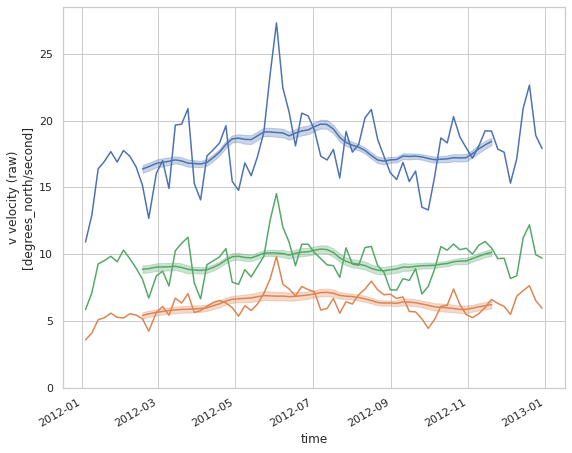

In [58]:
fig,ax = plt.subplots(1,figsize = (9,7),sharex=True)

# for i in range(16):
#     (16*total_sum_0.isel(subsetno=i).vol_trans_normal).plot(ax=ax,alpha=0.4,zorder=1)


labcu_sum_rolling = (labcu_sum_0.vol_trans_normal.sum(dim='subsetno')
                                                 .rolling(time=18,center=True).mean())
labcu_sum_0.vol_trans_normal.sum(dim='subsetno').plot(ax=ax,
                       color='C1',
                       zorder=10)
labcu_sum_rolling.plot(ax=ax,
                       color='C1',
                       zorder=10)
std = ((32*labcu_sum_0.vol_trans_normal.rolling(time=18,center=True).mean())
                                       .std(dim='subsetno'))
ax.fill_between(labcu_sum_0.time.data,
                labcu_sum_rolling+1.96*std,
                labcu_sum_rolling-1.96*std,
                color='C1',
                zorder=1,
                alpha=0.3)

gulfs_sum_rolling = (gulfs_sum_0.vol_trans_normal.sum(dim='subsetno')
                                                 .rolling(time=18,center=True).mean())
gulfs_sum_0.vol_trans_normal.sum(dim='subsetno').plot(ax=ax,
                       color='C2',
                       zorder=10)
gulfs_sum_rolling.plot(ax=ax,
                       color='C2',
                       zorder=10)
std = ((32*gulfs_sum_0.vol_trans_normal.rolling(time=18,center=True).mean())
                                       .std(dim='subsetno'))
ax.fill_between(gulfs_sum_0.time.data,
                gulfs_sum_rolling+1.96*std,
                gulfs_sum_rolling-1.96*std,
                color='C2',
                zorder=1,
                alpha=0.3)

ax.set_ylim(0)

In [58]:
labcu_sum_0.to_netcdf(output_data_path / str('labcu_sum_0_'+range_str+'_'+yearstr+'.nc'))
gulfs_sum_0.to_netcdf(output_data_path / str('gulfs_sum_0_'+range_str+'_'+yearstr+'.nc'))
lcdir_sum_0.to_netcdf(output_data_path / str('lcdir_sum_0_'+range_str+'_'+yearstr+'.nc'))
lc60w_sum_0.to_netcdf(output_data_path / str('lc60w_sum_0_'+range_str+'_'+yearstr+'.nc'))


In [59]:
labcu_mean_0.to_netcdf(output_data_path / str('labcu_mean_0_'+range_str+'_'+yearstr+'.nc'))
gulfs_mean_0.to_netcdf(output_data_path / str('gulfs_mean_0_'+range_str+'_'+yearstr+'.nc'))
lcdir_mean_0.to_netcdf(output_data_path / str('lcdir_mean_0_'+range_str+'_'+yearstr+'.nc'))
lc60w_mean_0.to_netcdf(output_data_path / str('lc60w_mean_0_'+range_str+'_'+yearstr+'.nc'))


In [60]:
labcu_sum_1.to_netcdf(output_data_path / str('labcu_sum_1_'+range_str+'_'+yearstr+'.nc'))
gulfs_sum_1.to_netcdf(output_data_path / str('gulfs_sum_1_'+range_str+'_'+yearstr+'.nc'))
lcdir_sum_1.to_netcdf(output_data_path / str('lcdir_sum_1_'+range_str+'_'+yearstr+'.nc'))
lc60w_sum_1.to_netcdf(output_data_path / str('lc60w_sum_1_'+range_str+'_'+yearstr+'.nc'))


In [61]:
labcu_mean_1.to_netcdf(output_data_path / str('labcu_mean_1_'+range_str+'_'+yearstr+'.nc'))
gulfs_mean_1.to_netcdf(output_data_path / str('gulfs_mean_1_'+range_str+'_'+yearstr+'.nc'))
lcdir_mean_1.to_netcdf(output_data_path / str('lcdir_mean_1_'+range_str+'_'+yearstr+'.nc'))
lc60w_mean_1.to_netcdf(output_data_path / str('lc60w_mean_1_'+range_str+'_'+yearstr+'.nc'))


In [ ]:
conda list